In [1]:
from pathlib import Path
import json

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from astropy.time import Time, TimezoneInfo
import astropy.units as u
from astropy.visualization import time_support
from astropy.table import Table
from astropy.coordinates import SkyCoord, EarthLocation, TETE
from astropy.table import Table
from astropy.io import ascii

from photutils.aperture import ApertureStats

from timdimm_tng.ser import load_ser_file
from timdimm_tng.analyze_cube import find_apertures, analyze_dimm_cube

time_support(simplify=True)

<astropy.visualization.time.time_support.<locals>.MplTimeConverter at 0x11fc94c50>

In [2]:
%load_ext autoreload
%autoreload 2
#%matplotlib widget

In [3]:
qe_tab = Table.read("~/MMT/timdimm_tng/notebooks/asi432mm_qe.csv", format="ascii.csv", names=["wavelength", "qe"])
np.sum(qe_tab["qe"] * qe_tab["wavelength"]) /np.sum(qe_tab["qe"])

639.375040081782

In [4]:
206265 * 9e-6 / 2.5

0.7425539999999999

In [5]:
plt.close('all')

In [22]:
testfile = Path.home() / "SAAO/timdimm_data/indi_2023-06-24/indi_record_2023-06-24@18-21-31.ser"
testfile = Path.home() / "SAAO/timdimm_data/indi_2023-06-24/indi_record_2023-06-24@18-18-32.ser"
testfile = Path.home() / "SAAO/timdimm_data/indi_2023-07-03/peacock.ser"
testfile = Path.home() / "find_boxes.ser"
#testfile = Path.home() / "seeing.ser"
#testfile = Path.home() / "SAAO/timdimm_data/indi_2023-12-08/indi_record_2023-12-08@20-48-35.ser"
#testfile = Path.home() / "SAAO/timdimm_data/indi_2024-01-20/indi_record_2024-01-20@02-33-24.ser"
d = load_ser_file(testfile)

In [23]:
d['data'].shape

(10, 1104, 1608)

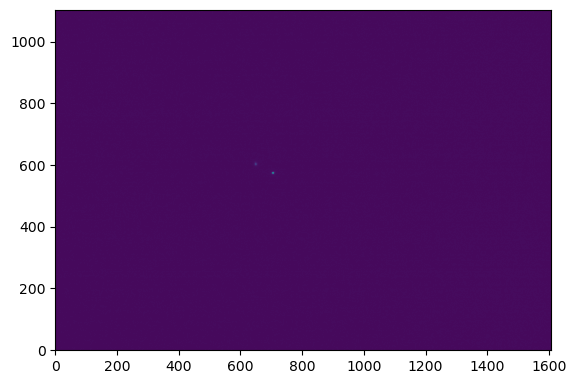

In [25]:
fig, ax = plt.subplots()
ax.imshow(np.mean(d["data"], axis=0), origin="lower")
plt.show()

In [7]:
np.mean(d["data"], axis=(1,2))

array([153.80363581, 153.72491708, 153.47242952, 153.43553969,
       153.6792577 , 153.71758058, 153.6474151 , 153.35409006,
       153.72607073, 153.88450862])

In [26]:
ap_im = np.mean(d["data"], axis=0)
aps = find_apertures(ap_im, fwhm=9)
ap_stats = ApertureStats(ap_im, aps[0])
np.mean(ap_stats.centroid, axis=0), (ap_stats.max.max() > 16000)

(array([678.4247842 , 587.23804121]), False)

In [133]:
ave_im = np.mean(d['data'][:10], axis=0)
aps = find_apertures(ave_im, brightest=2)
ap_stats = ApertureStats(ave_im, aps[0])
ap_stats.centroid, ap_stats.max, np.mean(ap_stats.centroid, axis=0)

(array([[280.14936248, 221.35899983],
        [233.85830466, 235.42737984]]),
 array([321.6, 236.8]),
 array([257.00383357, 228.39318983]))

In [128]:
ap_stats.max.max()

9356.8

In [129]:
x, y = np.mean(ap_stats.centroid, axis=0)
x, y

(198.98439414813674, 141.53435560117472)

In [178]:
airmass = 1/np.cos(90 * u.deg - 62 * u.deg)
airmass = 1.0
results = analyze_dimm_cube(testfile, airmass=airmass, plot=False)
print(f'{results["seeing"].value:.2f}')
results["seeing"]

1.74


<Quantity 1.74204521 arcsec>

In [101]:
results['N_bad']

1415

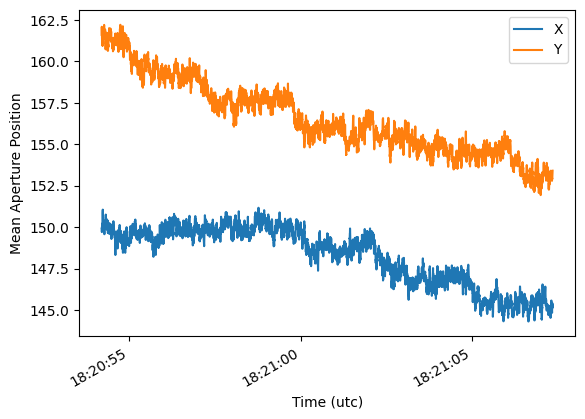

In [11]:
fig, ax = plt.subplots()
ax.plot(results["frame_times"], results["aperture_positions"][0], label='X')
ax.plot(results["frame_times"], results["aperture_positions"][1], label='Y')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.set_ylabel("Mean Aperture Position")
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

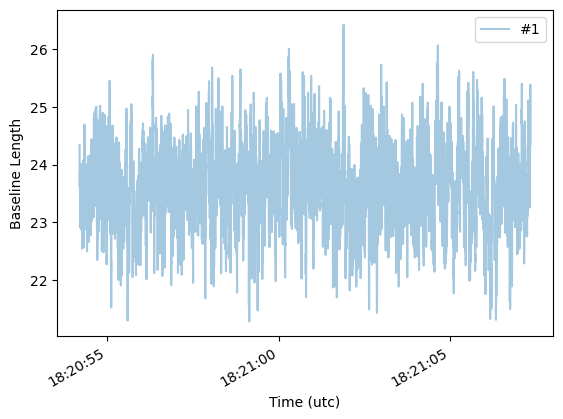

In [12]:
fig, ax = plt.subplots()
ax.plot(results["frame_times"], results["baseline_lengths"][0], label='#1', alpha=0.4)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.set_ylabel("Baseline Length")
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

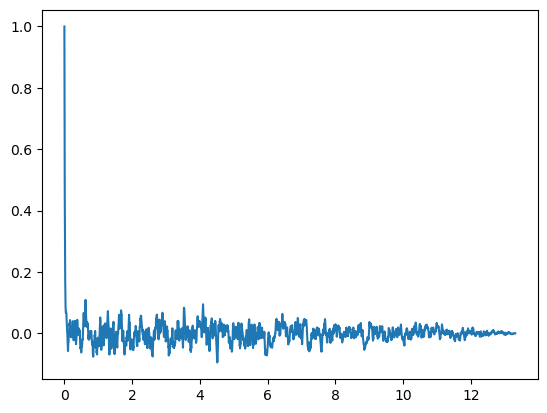

In [13]:
b0 = results["baseline_lengths"][0] - results["baseline_lengths"][0].mean()
dt = (results["frame_times"][1] - results["frame_times"][0]).to_value('sec')
autocor = np.correlate(b0, b0, mode='full')
autocor = autocor[autocor.size // 2 :]
fig = plt.figure()
plt.plot(dt * np.arange(autocor.size), autocor/autocor.max())
plt.show()

In [14]:
tobs = results['frame_times'][-1]

In [15]:
print(f'{results["seeing"]:.2f}')

1.02 arcsec


In [16]:
print(tobs.to_datetime(timezone=TimezoneInfo(utc_offset=2 * u.hour)))

2023-06-24 20:21:07.338829+02:00


In [17]:
from bs4 import BeautifulSoup
import requests

In [18]:
page = requests.get("https://suthweather.saao.ac.za/")
soup = BeautifulSoup(page.content, 'html.parser')

In [103]:
def hex2bin(str):
    """
    take a hexadecimal number as a string and convert it to a binary string
    """
    bin = [
        '0000', '0001', '0010', '0011',
        '0100', '0101', '0110', '0111',
        '1000', '1001', '1010', '1011',
        '1100', '1101', '1110', '1111'
    ]
    aa = ''
    for i in range(len(str)):
        aa += bin[int(str[i], base=16)]
    return aa

def checksum(str):
    """
    twos complement checksum as used by the ox wagon PLC
    """
    command = str[1:len(str) - 4]
    sum = 0
    for i in range(0, len(command), 2):
        byte = command[i] + command[i + 1]
        sum = sum + int(byte, base=16)
    neg = ~sum & 0xFF
    return neg + 1


In [106]:
checksum(':01101064000408' + '0000')

111

In [169]:
from timdimm_tng.wx.salt_weather_xml import parse_salt_xml as salt_wx
from timdimm_tng.wx.lcogt_weather import get_weather as lcogt_wx
from timdimm_tng.wx.lcogt_bwc2_weather import get_weather as lcogt_bwc2_wx
from timdimm_tng.wx.gfz_weather import get_weather as gfz_wx
from timdimm_tng.wx.check_wx import get_current_conditions

In [171]:
swx = salt_wx()
lwx = lcogt_wx()
gwx = gfz_wx()

In [117]:
Time(swx['TimeStamp_SAST'])

<Time object: scale='utc' format='datetime' value=2023-06-28 21:43:18>

In [180]:
cc, cc_checks = get_current_conditions()
all(cc_checks)

False

In [160]:
cc['SALT'].to(u.second).value

-7198.680580000004

In [172]:
swx, lwx, gwx

({'bms_validity': 511,
  'DateTime': '2023-06-28_22:49:27.62',
  'Bar_Press': 821.6397000000001,
  'DewTemp': 2.41875,
  'Rel_Hum': 97.99226,
  'Wind_speed': 27.98064,
  'Wind_dir': 260.69394,
  'Temp': 2.70172,
  'Rain': 0,
  'TimeStamp_SAST': datetime.datetime(2023, 6, 28, 22, 49, 28),
  'SkyCon': 'DRY',
  'Valid': True},
 {'TimeStamp_SAST': datetime.datetime(2023, 6, 28, 22, 47),
  'Temp': 2.0,
  'Wind_speed': 25.2,
  'Wind_dir': 240.0,
  'Rel_Hum': 99.0,
  'DewTemp': 1.9,
  'Bar_Press': 823.0,
  'SkyCon': 'DRY',
  'Valid': True},
 {'TimeStamp_SAST': datetime.datetime(2023, 6, 28, 22, 41),
  'Bar_Press': 821.84,
  'Wind_dir': 276.6,
  'Wind_speed': 26.3,
  'SkyCon': 'DRY',
  'Temp': 2.1,
  'Rel_Hum': 100.0,
  'DewTemp': 2.1,
  'Valid': True})

In [3]:
hadar = SkyCoord.from_name("Hadar")

In [4]:
hadar.to_string('hmsdms')

'14h03m49.40534952s -60d22m22.9265832s'

In [5]:
salt_loc = EarthLocation.of_site('Southern African Large Telescope')

In [6]:
hadar.transform_to(TETE(obstime=Time.now(), location=salt_loc)).to_string('hmsdms')

'14h05m29.60109118s -60d29m23.41570995s'

In [10]:
SkyCoord.from_name("Alnair").to_string('hmsdms')

'22h08m13.984728s -46d57m39.507768s'

In [33]:
t = ascii.read("../src/timdimm_tng/star.lst", format='fixed_width', delimiter='|')
t

HR,Name,RA2000,Dec2000,Vmag,B-V,SED,SpType,Duplicity
int64,str14,str8,str9,float64,float64,str3,str12,str15
98,Bet Hyi,0:25:45,-77:15:15,2.8,0.62,G05,G2IV,--
99,Ankaa,0:26:17,-42:18:22,2.39,1.09,K03,K0III,"0.1"" dm=0.0"
188,Diphda,0:43:35,-17:59:12,2.04,1.02,K03,G9.5IIICH-1,--
472,Achernar,1:37:43,-57:14:12,0.46,-0.16,B55,B3Vpe,--
591,Alp Hyi,1:58:46,-61:34:11,2.86,0.28,F05,F0V,--
1790,Bellatrix,5:25:08,+06:20:59,1.64,-0.22,B05,B2III,"179"" dm=10.5"
1865,Arneb,5:32:44,-17:49:20,2.58,0.21,F05,F0Ib,"AB 36"" dm=8.5"
1903,Alnilam,5:36:13,-01:12:07,1.7,-0.19,B05,B0Ia,"180"" dm=8.7"
1956,Phact,5:39:39,-34:04:27,2.64,-0.12,B55,B7IVe,"14"" dm=9.7"


In [34]:
coord_list = []
for r in t:
    print(r['Name'])
    coord_list.append(SkyCoord.from_name(r['Name']))

Bet Hyi
Ankaa
Diphda
Achernar
Alp Hyi
Bellatrix
Arneb
Alnilam
Phact
Saiph
Furud
Mirzam
Canopus
Sirius
Tau Pup
Omi2 CMa
Wezen
Pi Pup
Aludra
Procyon
Rho Pup
Suhail
Miaplacidus
Aspidiske
Kap Vel
Alphard
The Car
Mu  Vel
Del Cen
Del Cru
Gienah
Bet Crv
Alp Mus
Gam Cen
Mimosa
Gam Hya
Iot Cen
Spica
Eps Cen
Mu  Cen
Zet Cen
The Cen
Eta Cen
Alp Lup
Zubenelgenubi
Bet Lup
Gam TrA
Zubeneschamali
Bet TrA
Pi  Sco
Bet Sco
Sig Sco
Tau Sco
Atria
Eps Sco
Mu  Sco
Bet Ara
Lesath
Alp Ara
Shaula
The Sco
Kap Sco
Iot1 Sco
Alnasl
Kaus Media
Kaus Australis
Kaus Borealis
Nunki
Pi Sgr
Peacock
Deneb Algedi
Gam Gru
Alnair
Alp Tuc
Fomalhaut


In [36]:
t['Coordinates'] = coord_list

In [38]:
t.write("star_list.ecsv", format="ascii.ecsv", overwrite=True)

In [39]:
new_t = Table.read("star_list.ecsv", format="ascii.ecsv")

In [43]:
new_t

HR,Name,RA2000,Dec2000,Vmag,B-V,SED,SpType,Duplicity,Coordinates
,,,,,,,,,"deg,deg"
int64,str14,str8,str9,float64,float64,str3,str12,str15,SkyCoord
98,Bet Hyi,0:25:45,-77:15:15,2.8,0.62,G05,G2IV,--,"6.437793155,-77.25424612"
99,Ankaa,0:26:17,-42:18:22,2.39,1.09,K03,K0III,"0.1"" dm=0.0","6.571047515,-42.305987194"
188,Diphda,0:43:35,-17:59:12,2.04,1.02,K03,G9.5IIICH-1,--,"10.897378736,-17.986606316"
472,Achernar,1:37:43,-57:14:12,0.46,-0.16,B55,B3Vpe,--,"24.428522833,-57.236752806"
591,Alp Hyi,1:58:46,-61:34:11,2.86,0.28,F05,F0V,--,"29.69224409758834,-61.56982215319751"
1790,Bellatrix,5:25:08,+06:20:59,1.64,-0.22,B05,B2III,"179"" dm=10.5","81.282763557,6.349703264"
1865,Arneb,5:32:44,-17:49:20,2.58,0.21,F05,F0Ib,"AB 36"" dm=8.5","83.18256716167,-17.82228927222"
1903,Alnilam,5:36:13,-01:12:07,1.7,-0.19,B05,B0Ia,"180"" dm=8.7","84.053388941,-1.201919136"


In [1]:
new_t['Name'] == 'Tchou'

NameError: name 'new_t' is not defined

In [30]:
Time.now().isot

'2024-01-19T05:01:14.033'

In [34]:
status = {
    'target': "Tchou",
    'az': 234, # * u.degree,
    'el': 45, # * u.degree,
    'ra': 6, # * u.hourangle,
    'dec': -34, # * u.degree,
    'ha': 2, # * u.hourangle,
    'airmass': 1.54
}

with open(Path.home() / "pointing_status.json", 'w') as fp:
    fp.write(json.dumps(status, indent=4))